In [3]:
# Intialization
import os
import sys
import numpy as np

os.environ["SPARK_HOME"] = "/home/talentum/spark"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"

# In below two lines, use /usr/bin/python2.7 if you want to use Python 2
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.6" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/bin/python3"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0,org.apache.spark:spark-avro_2.11:2.4.3 pyspark-shell'


In [4]:
#Entrypoint
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("My work").enableHiveSupport().getOrCreate()

sc = spark.sparkContext

In [5]:
#-------------------------------------------------------------------------------------------------------------------------------
import pandas as pd
import numpy as np
from pmdarima import model_selection
from sklearn.metrics import mean_squared_error
from pyspark import SparkContext                                    # Importing SparkContext
from pyspark.sql import SparkSession, Window, Row                   # Importing importing methods for creating a cluster
from pyspark.sql import functions as F                              # Importing SQL Functions
from pyspark.sql.functions import col, isnan, when, count           # Importing relevant dataframe functions
from pyspark.sql.functions import *                                 # Importing inbuilt SQL Functions
from pyspark.sql.types import *                                     # Importing SQL types
#-------------------------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt                                     # Popular plotting library
% matplotlib inline                                                  # To plot graphs inline the notebook
import seaborn as sns                                               # Advanced plotting library
from handyspark import *                                            # Helper library to plot graphs
#-------------------------------------------------------------------------------------------------------------------------------
from pyspark.ml.feature import VectorAssembler                      # For processing dataset for ML
#-------------------------------------------------------------------------------------------------------------------------------
import warnings                                                     # Importing warning to disable runtime warnings
warnings.filterwarnings("ignore")                                   # Warnings will appear only once
#-------------------------------------------------------------------------------------------------------------------------------

UsageError: Line magic function `%` not found.


In [8]:
filepath = "file:///home/talentum/shared/state3.csv"
df = spark.read.csv(filepath, header=True, inferSchema=True)

In [9]:
df.printSchema()

root
 |-- bp_mmhg: double (nullable = true)
 |-- benzene_ug_m3: double (nullable = true)
 |-- mp_xylene_ug_m3: double (nullable = true)
 |-- o_xylene_ug_m3: string (nullable = true)
 |-- xylene_ug_m3: string (nullable = true)
 |-- co_mg_m3: double (nullable = true)
 |-- nh3_ug_m3: double (nullable = true)
 |-- so2_ug_m3: double (nullable = true)
 |-- at_degree: string (nullable = true)
 |-- rf_mm: double (nullable = true)
 |-- temp_degree_c: string (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- eth_benzene_ug_m3: double (nullable = true)
 |-- state: string (nullable = true)
 |-- temp_: string (nullable = true)
 |-- at_degree_c: double (nullable = true)
 |-- wd_degree: double (nullable = true)
 |-- wd_deg: string (nullable = true)
 |-- nox_ppb: double (nullable = true)
 |-- no_ug_m3: double (nullable = true)
 |-- toluene_ug_m3: double (nullable = true)
 |-- rh_degree: double (nullable = true)
 |-- nox_ug_m3: double (nullable = true)
 |-- to_date: timestamp (nullable 

In [10]:
# Shape of the dataset
print('Shape of the dataset: ', (df.count(), len(df.columns)))

Shape of the dataset:  (110811, 32)


In [11]:
df.select("from_date").show(5)

+-------------------+
|          from_date|
+-------------------+
|2020-03-21 02:00:00|
|2020-03-24 17:00:00|
|2020-03-24 23:00:00|
|2020-03-28 09:00:00|
|2020-04-13 11:00:00|
+-------------------+
only showing top 5 rows



In [12]:
print("Let's print first 5 data rows:")
df.limit(5).toPandas()

Let's print first 5 data rows:


,bp_mmhg,benzene_ug_m3,mp_xylene_ug_m3,o_xylene_ug_m3,xylene_ug_m3,co_mg_m3,nh3_ug_m3,so2_ug_m3,at_degree,rf_mm,...,nox_ug_m3,to_date,ozone_ug_m3,pm10_ug_m3,sr_w_mt2,vws_m_s,ws_m_s,no2_ug_m3,pm2_5_ug_m3,rh_%
0,889.33,0.01,0.10,None,None,0.44,17.88,5.03,None,None,...,None,2020-03-21 03:00:00,5.88,65.14,None,None,0.95,0.13,7.00,75.25
1,888.42,0.14,0.49,None,None,0.32,24.02,6.85,None,None,...,None,2020-03-24 18:00:00,6.34,51.53,None,None,0.70,0.26,7.00,56.97
2,889.86,0.01,0.68,None,None,0.49,18.43,5.80,None,None,...,None,2020-03-25 00:00:00,5.28,91.00,None,None,0.83,0.09,7.00,66.27
3,891.36,0.19,0.51,None,None,0.32,24.60,7.07,None,None,...,None,2020-03-28 10:00:00,8.40,41.66,None,None,1.73,0.08,26.16,43.23
4,888.42,0.11,0.49,None,None,0.32,27.36,5.20,None,None,...,None,2020-04-13 12:00:00,3.50,33.00,None,None,2.38,0.96,27.11,32.88


In [13]:
# Selecting multiple columns
df.select(['xylene_ug_m3','state']).show(10)

+------------+-------+
|xylene_ug_m3|  state|
+------------+-------+
|        null|Mizoram|
|        null|Mizoram|
|        null|Mizoram|
|        null|Mizoram|
|        null|Mizoram|
|        null|Mizoram|
|        null|Mizoram|
|        null|Mizoram|
|        null|Mizoram|
|        null|Mizoram|
+------------+-------+
only showing top 10 rows



In [14]:
# Get a list of all column names and their data types
column_info = df.dtypes

# Filter the list to only include numerical columns
numerical_columns = [col[0] for col in column_info if col[1] in ("IntegerType", "double")]
string_columns = [col[0] for col in column_info if col[1] == "string"]

print("All Numerial columns:")
print(numerical_columns)
print("\n")
print("All string columns:")
print(string_columns)

All Numerial columns:
['bp_mmhg', 'benzene_ug_m3', 'mp_xylene_ug_m3', 'co_mg_m3', 'nh3_ug_m3', 'so2_ug_m3', 'rf_mm', 'eth_benzene_ug_m3', 'at_degree_c', 'wd_degree', 'nox_ppb', 'no_ug_m3', 'toluene_ug_m3', 'rh_degree', 'nox_ug_m3', 'ozone_ug_m3', 'pm10_ug_m3', 'ws_m_s', 'no2_ug_m3', 'pm2_5_ug_m3', 'rh_%']


All string columns:
['o_xylene_ug_m3', 'xylene_ug_m3', 'at_degree', 'temp_degree_c', 'state', 'temp_', 'wd_deg', 'sr_w_mt2', 'vws_m_s']


In [15]:
from pyspark.sql.functions import to_timestamp

df = df.withColumn("from_date", to_timestamp(df["from_date"], "dd-MM-yyyy"))
df= df.withColumn("to_date", to_timestamp(df["to_date"], "dd-MM-yyyy"))

In [16]:
columns_to_cast = [c for c in df.columns if c not in ['state','from_date','to_date']]
for c in columns_to_cast:
    df = df.withColumn(c, col(c).cast("double"))    

In [17]:
numerical_columns_new = [col[0] for col in df.dtypes if col[1] in ("IntegerType", "double")]
string_columns_new = [col[0] for col in df.dtypes if col[1] == "string"]

print("All Numerial columns:")
print(numerical_columns_new)
print("\n")
print("All string columns:")
print(string_columns_new)

All Numerial columns:
['bp_mmhg', 'benzene_ug_m3', 'mp_xylene_ug_m3', 'o_xylene_ug_m3', 'xylene_ug_m3', 'co_mg_m3', 'nh3_ug_m3', 'so2_ug_m3', 'at_degree', 'rf_mm', 'temp_degree_c', 'eth_benzene_ug_m3', 'temp_', 'at_degree_c', 'wd_degree', 'wd_deg', 'nox_ppb', 'no_ug_m3', 'toluene_ug_m3', 'rh_degree', 'nox_ug_m3', 'ozone_ug_m3', 'pm10_ug_m3', 'sr_w_mt2', 'vws_m_s', 'ws_m_s', 'no2_ug_m3', 'pm2_5_ug_m3', 'rh_%']


All string columns:
['state']


In [18]:
df.printSchema()

root
 |-- bp_mmhg: double (nullable = true)
 |-- benzene_ug_m3: double (nullable = true)
 |-- mp_xylene_ug_m3: double (nullable = true)
 |-- o_xylene_ug_m3: double (nullable = true)
 |-- xylene_ug_m3: double (nullable = true)
 |-- co_mg_m3: double (nullable = true)
 |-- nh3_ug_m3: double (nullable = true)
 |-- so2_ug_m3: double (nullable = true)
 |-- at_degree: double (nullable = true)
 |-- rf_mm: double (nullable = true)
 |-- temp_degree_c: double (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- eth_benzene_ug_m3: double (nullable = true)
 |-- state: string (nullable = true)
 |-- temp_: double (nullable = true)
 |-- at_degree_c: double (nullable = true)
 |-- wd_degree: double (nullable = true)
 |-- wd_deg: double (nullable = true)
 |-- nox_ppb: double (nullable = true)
 |-- no_ug_m3: double (nullable = true)
 |-- toluene_ug_m3: double (nullable = true)
 |-- rh_degree: double (nullable = true)
 |-- nox_ug_m3: double (nullable = true)
 |-- to_date: timestamp (nullable 

In [19]:
df.select("from_date").show(5)

+-------------------+
|          from_date|
+-------------------+
|2020-03-21 02:00:00|
|2020-03-24 17:00:00|
|2020-03-24 23:00:00|
|2020-03-28 09:00:00|
|2020-04-13 11:00:00|
+-------------------+
only showing top 5 rows



In [20]:
distinct_state_count = df.select("state").distinct().count()
print(f"Number of distinct states: {distinct_state_count}")
df.select("state").distinct().show()

Number of distinct states: 3
+--------+
|   state|
+--------+
|Nagaland|
|  Odisha|
| Mizoram|
+--------+



In [21]:
df.groupBy("state").count().orderBy("state").show(31,truncate=False)

+--------+-----+
|state   |count|
+--------+-----+
|Mizoram |24991|
|Nagaland|21414|
|Odisha  |64406|
+--------+-----+



In [22]:
df1=df

In [23]:
for col_name in df1.columns:
    null_count=df1.filter(col(col_name).isNull()).count()
    print(f"'{col_name}':'{null_count}'")

'bp_mmhg':'64406'
'benzene_ug_m3':'0'
'mp_xylene_ug_m3':'0'
'o_xylene_ug_m3':'110811'
'xylene_ug_m3':'110811'
'co_mg_m3':'0'
'nh3_ug_m3':'0'
'so2_ug_m3':'0'
'at_degree':'110811'
'rf_mm':'89397'
'temp_degree_c':'110811'
'from_date':'0'
'eth_benzene_ug_m3':'0'
'state':'0'
'temp_':'110811'
'at_degree_c':'24991'
'wd_degree':'0'
'wd_deg':'110811'
'nox_ppb':'64406'
'no_ug_m3':'0'
'toluene_ug_m3':'46405'
'rh_degree':'46405'
'nox_ug_m3':'46405'
'to_date':'0'
'ozone_ug_m3':'0'
'pm10_ug_m3':'0'
'sr_w_mt2':'110811'
'vws_m_s':'110811'
'ws_m_s':'0'
'no2_ug_m3':'0'
'pm2_5_ug_m3':'0'
'rh_%':'64406'


In [24]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, lit

spark = SparkSession.builder.appName("NullPercentage").getOrCreate()

# Define a function to calculate null percentages for numeric and non-numeric columns
def calculate_null_percentage(df):
    total_count = df.count()
    exprs = []

    for c in df.columns:
        if dict(df.dtypes)[c] in ['double', 'float', 'int']:
            exprs.append((count(when(col(c).isNull() | isnan(c), c)) / total_count).alias(c))
        else:
            exprs.append((count(when(col(c).isNull(), c)) / total_count).alias(c))

    return df.select(exprs)

# Calculate the null percentage for each column
null_percentage_df = calculate_null_percentage(df1)

# Show the null percentages
null_percentage_df.toPandas().transpose()


,0
bp_mmhg,0.581224
benzene_ug_m3,0.000000
mp_xylene_ug_m3,0.000000
o_xylene_ug_m3,1.000000
xylene_ug_m3,1.000000
co_mg_m3,0.000000
nh3_ug_m3,0.000000
so2_ug_m3,0.000000
at_degree,1.000000
rf_mm,0.806752


In [25]:
# Convert the null percentage DataFrame to a dictionary for easy access
null_percentages = null_percentage_df.collect()[0].asDict()

# Define the threshold for dropping columns (50% in this case)
threshold = 0.50

# Select the columns to keep (those with null percentage <= 50%)
columns_to_keep = [col for col, pct in null_percentages.items() if pct <= threshold]
print("Columns to keep:")
print(columns_to_keep)

# Create a new DataFrame with the selected columns
df_filtered = df.select(columns_to_keep)

# Show the new DataFrame
#df_filtered.show(truncate=False)
df_filtered.toPandas()

Columns to keep:
['benzene_ug_m3', 'mp_xylene_ug_m3', 'co_mg_m3', 'nh3_ug_m3', 'so2_ug_m3', 'from_date', 'eth_benzene_ug_m3', 'state', 'at_degree_c', 'wd_degree', 'no_ug_m3', 'toluene_ug_m3', 'rh_degree', 'nox_ug_m3', 'to_date', 'ozone_ug_m3', 'pm10_ug_m3', 'ws_m_s', 'no2_ug_m3', 'pm2_5_ug_m3']


,benzene_ug_m3,mp_xylene_ug_m3,co_mg_m3,nh3_ug_m3,so2_ug_m3,from_date,eth_benzene_ug_m3,state,at_degree_c,wd_degree,no_ug_m3,toluene_ug_m3,rh_degree,nox_ug_m3,to_date,ozone_ug_m3,pm10_ug_m3,ws_m_s,no2_ug_m3,pm2_5_ug_m3
0,0.01,0.10,0.44,17.88,5.03,2020-03-21 02:00:00,0.08,Mizoram,NaN,272.75,2.83,NaN,NaN,NaN,2020-03-21 03:00:00,5.88,65.14,0.95,0.13,7.00
1,0.14,0.49,0.32,24.02,6.85,2020-03-24 17:00:00,0.28,Mizoram,NaN,242.77,3.05,NaN,NaN,NaN,2020-03-24 18:00:00,6.34,51.53,0.70,0.26,7.00
2,0.01,0.68,0.49,18.43,5.80,2020-03-24 23:00:00,0.39,Mizoram,NaN,262.43,2.89,NaN,NaN,NaN,2020-03-25 00:00:00,5.28,91.00,0.83,0.09,7.00
3,0.19,0.51,0.32,24.60,7.07,2020-03-28 09:00:00,0.30,Mizoram,NaN,240.70,2.86,NaN,NaN,NaN,2020-03-28 10:00:00,8.40,41.66,1.73,0.08,26.16
4,0.11,0.49,0.32,27.36,5.20,2020-04-13 11:00:00,0.25,Mizoram,NaN,184.42,5.06,NaN,NaN,NaN,2020-04-13 12:00:00,3.50,33.00,2.38,0.96,27.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110806,1.53,1.26,1.51,16.69,3.00,2022-12-04 22:00:00,1.10,Odisha,25.55,7.88,10.30,0.63,71.37,70.85,2022-12-04 23:00:00,9.34,117.11,0.10,45.63,72.75
110807,0.97,1.02,1.47,16.69,3.00,2022-12-05 05:00:00,0.84,Odisha,25.55,7.88,10.30,0.63,71.37,19.73,2022-12-05 06:00:00,9.10,166.86,0.09,53.48,102.19
110808,0.79,0.86,1.08,16.69,3.94,2022-12-06 16:00:00,0.77,Odisha,25.55,38.28,10.30,0.63,71.37,19.73,2022-12-06 17:00:00,10.30,85.96,0.31,55.73,54.79
110809,1.47,1.10,1.19,16.69,2.92,2022-12-12 19:00:00,0.65,Odisha,25.55,8.33,10.30,0.63,71.37,19.73,2022-12-12 20:00:00,9.42,104.45,0.13,15.08,55.69


In [26]:
df_filtered.printSchema()

root
 |-- benzene_ug_m3: double (nullable = true)
 |-- mp_xylene_ug_m3: double (nullable = true)
 |-- co_mg_m3: double (nullable = true)
 |-- nh3_ug_m3: double (nullable = true)
 |-- so2_ug_m3: double (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- eth_benzene_ug_m3: double (nullable = true)
 |-- state: string (nullable = true)
 |-- at_degree_c: double (nullable = true)
 |-- wd_degree: double (nullable = true)
 |-- no_ug_m3: double (nullable = true)
 |-- toluene_ug_m3: double (nullable = true)
 |-- rh_degree: double (nullable = true)
 |-- nox_ug_m3: double (nullable = true)
 |-- to_date: timestamp (nullable = true)
 |-- ozone_ug_m3: double (nullable = true)
 |-- pm10_ug_m3: double (nullable = true)
 |-- ws_m_s: double (nullable = true)
 |-- no2_ug_m3: double (nullable = true)
 |-- pm2_5_ug_m3: double (nullable = true)



In [28]:
#df2=df_filtered.dropna()

In [29]:
#df2.count()

In [30]:
#import pyspark
#pyspark.__version__
#pip install --upgrade pyspark

## Imputing Null values

In [31]:
from pyspark.sql.types import IntegerType, FloatType, DoubleType
from pyspark.ml.feature import Imputer

numeric_column_names = [column.name for column in df_filtered.schema.fields
                        if isinstance(column.dataType, (IntegerType, FloatType, DoubleType))]


# Initialize the Imputer
imputer = Imputer(
    inputCols= numeric_column_names, #specifying the input column names
    outputCols=numeric_column_names, #specifying the output column names
    strategy="median"                  # "median" if you want to use the median value
)

# Fit the Imputer
model = imputer.fit(df_filtered)

#Transform the dataset
imputed_df = model.transform(df_filtered)


In [32]:
# Check: After Imputing percentage of null values
new_df=calculate_null_percentage(imputed_df)
new_df.toPandas().transpose()

,0
benzene_ug_m3,0.0
mp_xylene_ug_m3,0.0
co_mg_m3,0.0
nh3_ug_m3,0.0
so2_ug_m3,0.0
from_date,0.0
eth_benzene_ug_m3,0.0
state,0.0
at_degree_c,0.0
wd_degree,0.0


In [33]:
pdf = imputed_df

## Cleaned File

In [34]:
#imputed_df.coalesce(1).write.parquet("file:///home/talentum/P2/Imputed")

In [35]:
imputed_df.limit(5).toPandas()

,benzene_ug_m3,mp_xylene_ug_m3,co_mg_m3,nh3_ug_m3,so2_ug_m3,from_date,eth_benzene_ug_m3,state,at_degree_c,wd_degree,no_ug_m3,toluene_ug_m3,rh_degree,nox_ug_m3,to_date,ozone_ug_m3,pm10_ug_m3,ws_m_s,no2_ug_m3,pm2_5_ug_m3
0,0.01,0.10,0.44,17.88,5.03,2020-03-21 02:00:00,0.08,Mizoram,25.55,272.75,2.83,0.63,71.37,19.73,2020-03-21 03:00:00,5.88,65.14,0.95,0.13,7.00
1,0.14,0.49,0.32,24.02,6.85,2020-03-24 17:00:00,0.28,Mizoram,25.55,242.77,3.05,0.63,71.37,19.73,2020-03-24 18:00:00,6.34,51.53,0.70,0.26,7.00
2,0.01,0.68,0.49,18.43,5.80,2020-03-24 23:00:00,0.39,Mizoram,25.55,262.43,2.89,0.63,71.37,19.73,2020-03-25 00:00:00,5.28,91.00,0.83,0.09,7.00
3,0.19,0.51,0.32,24.60,7.07,2020-03-28 09:00:00,0.30,Mizoram,25.55,240.70,2.86,0.63,71.37,19.73,2020-03-28 10:00:00,8.40,41.66,1.73,0.08,26.16
4,0.11,0.49,0.32,27.36,5.20,2020-04-13 11:00:00,0.25,Mizoram,25.55,184.42,5.06,0.63,71.37,19.73,2020-04-13 12:00:00,3.50,33.00,2.38,0.96,27.11


In [36]:
from pyspark.sql import functions as F
from pyspark.sql import DataFrame

def calculate_aqi(df: DataFrame) -> DataFrame:
    return df.withColumn(
        "AQI_Category",
        F.when(
            (F.col("pm2_5_ug_m3") <= 30) & (F.col("pm10_ug_m3") <= 50) & (F.col("so2_ug_m3") <= 40) & (F.col("no2_ug_m3") <= 40),
            "Good"
        ).when(
            (F.col("pm2_5_ug_m3") <= 60) & (F.col("pm10_ug_m3") <= 100) & (F.col("so2_ug_m3") <= 80) & (F.col("no2_ug_m3") <= 80),
            "Moderate"
        ).when(
            (F.col("pm2_5_ug_m3") <= 90) & (F.col("pm10_ug_m3") <= 250) & (F.col("so2_ug_m3") <= 380) & (F.col("no2_ug_m3") <= 180),
            "Unhealthy"
        ).when(
            (F.col("pm2_5_ug_m3") > 120) | (F.col("pm10_ug_m3") > 350) | (F.col("so2_ug_m3") > 800) & (F.col("no2_ug_m3") <= 280),
            "Very Unhealthy"
        ).otherwise("Hazardous")
    )

df_with_aqi = calculate_aqi(pdf)


In [37]:
df_with_aqi.limit(5).toPandas()

,benzene_ug_m3,mp_xylene_ug_m3,co_mg_m3,nh3_ug_m3,so2_ug_m3,from_date,eth_benzene_ug_m3,state,at_degree_c,wd_degree,...,toluene_ug_m3,rh_degree,nox_ug_m3,to_date,ozone_ug_m3,pm10_ug_m3,ws_m_s,no2_ug_m3,pm2_5_ug_m3,AQI_Category
0,0.01,0.10,0.44,17.88,5.03,2020-03-21 02:00:00,0.08,Mizoram,25.55,272.75,...,0.63,71.37,19.73,2020-03-21 03:00:00,5.88,65.14,0.95,0.13,7.00,Moderate
1,0.14,0.49,0.32,24.02,6.85,2020-03-24 17:00:00,0.28,Mizoram,25.55,242.77,...,0.63,71.37,19.73,2020-03-24 18:00:00,6.34,51.53,0.70,0.26,7.00,Moderate
2,0.01,0.68,0.49,18.43,5.80,2020-03-24 23:00:00,0.39,Mizoram,25.55,262.43,...,0.63,71.37,19.73,2020-03-25 00:00:00,5.28,91.00,0.83,0.09,7.00,Moderate
3,0.19,0.51,0.32,24.60,7.07,2020-03-28 09:00:00,0.30,Mizoram,25.55,240.70,...,0.63,71.37,19.73,2020-03-28 10:00:00,8.40,41.66,1.73,0.08,26.16,Good
4,0.11,0.49,0.32,27.36,5.20,2020-04-13 11:00:00,0.25,Mizoram,25.55,184.42,...,0.63,71.37,19.73,2020-04-13 12:00:00,3.50,33.00,2.38,0.96,27.11,Good


In [38]:
df_with_aqi.groupBy("AQI_Category").count().orderBy("AQI_Category").show()

+--------------+-----+
|  AQI_Category|count|
+--------------+-----+
|          Good|34253|
|     Hazardous| 7373|
|      Moderate|40348|
|     Unhealthy|25690|
|Very Unhealthy| 3147|
+--------------+-----+



In [39]:
print(df_with_aqi.columns)

['benzene_ug_m3', 'mp_xylene_ug_m3', 'co_mg_m3', 'nh3_ug_m3', 'so2_ug_m3', 'from_date', 'eth_benzene_ug_m3', 'state', 'at_degree_c', 'wd_degree', 'no_ug_m3', 'toluene_ug_m3', 'rh_degree', 'nox_ug_m3', 'to_date', 'ozone_ug_m3', 'pm10_ug_m3', 'ws_m_s', 'no2_ug_m3', 'pm2_5_ug_m3', 'AQI_Category']


## Feature Selection

In [40]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline



# Encode the target column 'AQI_Category' if it's categorical
indexer = StringIndexer(inputCol='AQI_Category', outputCol='label')

# Define the features (excluding the target and any irrelevant columns)
feature_columns = ['benzene_ug_m3', 'mp_xylene_ug_m3', 'co_mg_m3', 'nh3_ug_m3', 'so2_ug_m3', 
                   'eth_benzene_ug_m3', 'at_degree_c', 'wd_degree', 'no_ug_m3', 'toluene_ug_m3', 
                   'rh_degree', 'nox_ug_m3', 'ozone_ug_m3', 'pm10_ug_m3', 'ws_m_s', 'no2_ug_m3', 
                   'pm2_5_ug_m3']


# Assemble features into a feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Create a pipeline to apply StringIndexer and VectorAssembler
pipeline = Pipeline(stages=[indexer, assembler])

# Fit and transform the data
df_prepared = pipeline.fit(df_with_aqi).transform(df_with_aqi)

# Show the prepared data
df_prepared.toPandas()



,benzene_ug_m3,mp_xylene_ug_m3,co_mg_m3,nh3_ug_m3,so2_ug_m3,from_date,eth_benzene_ug_m3,state,at_degree_c,wd_degree,...,nox_ug_m3,to_date,ozone_ug_m3,pm10_ug_m3,ws_m_s,no2_ug_m3,pm2_5_ug_m3,AQI_Category,label,features
0,0.01,0.10,0.44,17.88,5.03,2020-03-21 02:00:00,0.08,Mizoram,25.55,272.75,...,19.73,2020-03-21 03:00:00,5.88,65.14,0.95,0.13,7.00,Moderate,0.0,"[0.01, 0.1, 0.44, 17.88, 5.03, 0.08, 25.55, 27..."
1,0.14,0.49,0.32,24.02,6.85,2020-03-24 17:00:00,0.28,Mizoram,25.55,242.77,...,19.73,2020-03-24 18:00:00,6.34,51.53,0.70,0.26,7.00,Moderate,0.0,"[0.14, 0.49, 0.32, 24.02, 6.85, 0.28, 25.55, 2..."
2,0.01,0.68,0.49,18.43,5.80,2020-03-24 23:00:00,0.39,Mizoram,25.55,262.43,...,19.73,2020-03-25 00:00:00,5.28,91.00,0.83,0.09,7.00,Moderate,0.0,"[0.01, 0.68, 0.49, 18.43, 5.8, 0.39, 25.55, 26..."
3,0.19,0.51,0.32,24.60,7.07,2020-03-28 09:00:00,0.30,Mizoram,25.55,240.70,...,19.73,2020-03-28 10:00:00,8.40,41.66,1.73,0.08,26.16,Good,1.0,"[0.19, 0.51, 0.32, 24.6, 7.07, 0.3, 25.55, 240..."
4,0.11,0.49,0.32,27.36,5.20,2020-04-13 11:00:00,0.25,Mizoram,25.55,184.42,...,19.73,2020-04-13 12:00:00,3.50,33.00,2.38,0.96,27.11,Good,1.0,"[0.11, 0.49, 0.32, 27.36, 5.2, 0.25, 25.55, 18..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110806,1.53,1.26,1.51,16.69,3.00,2022-12-04 22:00:00,1.10,Odisha,25.55,7.88,...,70.85,2022-12-04 23:00:00,9.34,117.11,0.10,45.63,72.75,Unhealthy,2.0,"[1.53, 1.26, 1.51, 16.69, 3.0, 1.1, 25.55, 7.8..."
110807,0.97,1.02,1.47,16.69,3.00,2022-12-05 05:00:00,0.84,Odisha,25.55,7.88,...,19.73,2022-12-05 06:00:00,9.10,166.86,0.09,53.48,102.19,Hazardous,3.0,"[0.97, 1.02, 1.47, 16.69, 3.0, 0.84, 25.55, 7...."
110808,0.79,0.86,1.08,16.69,3.94,2022-12-06 16:00:00,0.77,Odisha,25.55,38.28,...,19.73,2022-12-06 17:00:00,10.30,85.96,0.31,55.73,54.79,Moderate,0.0,"[0.79, 0.86, 1.08, 16.69, 3.94, 0.77, 25.55, 3..."
110809,1.47,1.10,1.19,16.69,2.92,2022-12-12 19:00:00,0.65,Odisha,25.55,8.33,...,19.73,2022-12-12 20:00:00,9.42,104.45,0.13,15.08,55.69,Unhealthy,2.0,"[1.47, 1.1, 1.19, 16.69, 2.92, 0.65, 25.55, 8...."


In [41]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler

# Initialize the Random Forest model
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)

# Train the model
rf_model = rf.fit(df_prepared)

# Extract feature importances
importances = rf_model.featureImportances

# Create a list of (feature, importance) tuples
feature_importance_list = [(feature, importance) for feature, importance in zip(feature_columns, importances)]
print(feature_importance_list)



[('benzene_ug_m3', 0.002688161692658697), ('mp_xylene_ug_m3', 0.012441214643179578), ('co_mg_m3', 0.02357526790031526), ('nh3_ug_m3', 0.0023528995071673683), ('so2_ug_m3', 0.018169116201895874), ('eth_benzene_ug_m3', 0.004555404406816805), ('at_degree_c', 0.0011967150959230682), ('wd_degree', 0.0011010439683332843), ('no_ug_m3', 0.004583911583176643), ('toluene_ug_m3', 0.0004724601972186538), ('rh_degree', 0.0006171523345909084), ('nox_ug_m3', 0.0013562258668217354), ('ozone_ug_m3', 0.012462995006689796), ('pm10_ug_m3', 0.5239789672173877), ('ws_m_s', 0.005158882713228365), ('no2_ug_m3', 0.036017860410299314), ('pm2_5_ug_m3', 0.3492717212542969)]


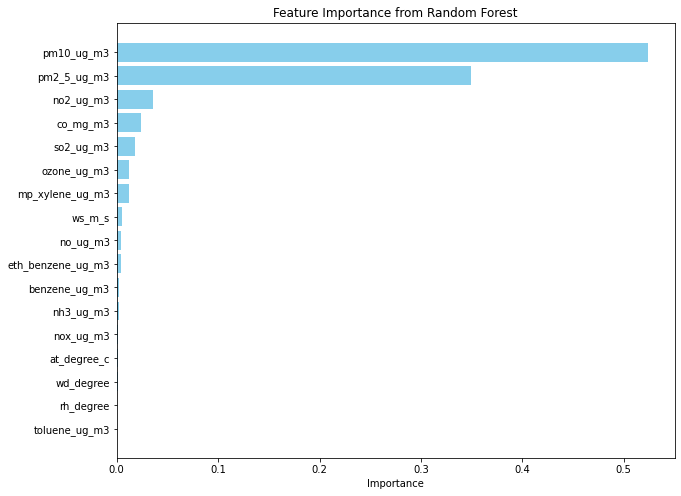

In [42]:
# Convert the feature importance list to a Pandas DataFrame for easier plotting
importance_df = pd.DataFrame(feature_importance_list, columns=['Feature', 'Importance'])

# Sort the DataFrame by importance for better visualization
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features on top
plt.show()

In [43]:
selected_features = [feature for feature, importance in feature_importance_list if importance >0.012446]

# Add additional columns like 'from_date', 'to_date', 'state'
selected_features.extend(['from_date', 'to_date', 'state',"AQI_Category"])

# Create a new DataFrame with the selected features
new_df = df_with_aqi.select(*selected_features)

# Show the new DataFrame with selected features
new_df.show()

+--------+---------+-----------+----------+---------+-----------+-------------------+-------------------+-------+------------+
|co_mg_m3|so2_ug_m3|ozone_ug_m3|pm10_ug_m3|no2_ug_m3|pm2_5_ug_m3|          from_date|            to_date|  state|AQI_Category|
+--------+---------+-----------+----------+---------+-----------+-------------------+-------------------+-------+------------+
|    0.44|     5.03|       5.88|     65.14|     0.13|        7.0|2020-03-21 02:00:00|2020-03-21 03:00:00|Mizoram|    Moderate|
|    0.32|     6.85|       6.34|     51.53|     0.26|        7.0|2020-03-24 17:00:00|2020-03-24 18:00:00|Mizoram|    Moderate|
|    0.49|      5.8|       5.28|      91.0|     0.09|        7.0|2020-03-24 23:00:00|2020-03-25 00:00:00|Mizoram|    Moderate|
|    0.32|     7.07|        8.4|     41.66|     0.08|      26.16|2020-03-28 09:00:00|2020-03-28 10:00:00|Mizoram|        Good|
|    0.32|      5.2|        3.5|      33.0|     0.96|      27.11|2020-04-13 11:00:00|2020-04-13 12:00:00|Mizora

In [44]:
#!pip install scikit-learn
#!pip install plotly

In [45]:
#from sklearn.preprocessing import StandardScaler
#import plotly.graph_objs as go
#from plotly import __version__
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

#init_notebook_mode(connected=True)
#data=[
#    go.Scatter(x=df_with_aqi1.from_date, y=df_with_aqi1.no2_ug_m3[df_with_aqi1.AQI_Category=='Good'], name='NO2')
#]
#iplot({'data':data, 'layout':{'title':'Equity R price trace on 2016-01-28', 'font': dict(size=10)}})

## Prediction Models

In [46]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator

### 1) First, let's prepare the data for modeling.

In [47]:
# StringIndexer for the categorical target column
indexer = StringIndexer(inputCol='AQI_Category', outputCol='label')

# VectorAssembler to combine feature columns into a single vector
feature_cols = [col for col in new_df.columns if col not in ['AQI_Category', 'from_date', 'to_date', 'state']]
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

# Split the data into training and testing sets
train_df, test_df = new_df.randomSplit([0.8, 0.2], seed=42)

### 2) Model Building with Hyperparameter Tuning
Now, let's define the models with hyperparameter grids and use cross-validation for tuning.

In [48]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Import the machine learning models
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier

# Define models
lr = LogisticRegression(maxIter=10)
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

# Define hyperparameter grids
lr_param_grid = (ParamGridBuilder()
                 .addGrid(lr.regParam, [0.1, 0.01])
                 .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
                 .build())

dt_param_grid = (ParamGridBuilder()
                 .addGrid(dt.maxDepth, [5, 10, 20])
                 .addGrid(dt.maxBins, [32, 64])
                 .build())

rf_param_grid = (ParamGridBuilder()
                 .addGrid(rf.numTrees, [20, 50])
                 .addGrid(rf.maxDepth, [5, 10])
                 .build())

# Define CrossValidator
crossval = CrossValidator(estimator=None,
                          estimatorParamMaps=None,
                          evaluator=MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy'),
                          numFolds=3)

# Set up pipelines and cross-validate each model
def cross_validate_model(model, param_grid, train_df):
    pipeline = Pipeline(stages=[indexer, assembler, model])
    crossval.setEstimator(pipeline)
    crossval.setEstimatorParamMaps(param_grid)
    cv_model = crossval.fit(train_df)
    return cv_model

# Train and tune models
lr_model = cross_validate_model(lr, lr_param_grid, train_df)
dt_model = cross_validate_model(dt, dt_param_grid, train_df)
rf_model = cross_validate_model(rf, rf_param_grid, train_df)  

### 3) Model Evaluation
After tuning the models, let's evaluate their performance on the test dataset.

In [49]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate models
models = ['Logistic Regression', 'Decision Tree', 'Random Forest']
predictions = [lr_model.transform(test_df), 
               dt_model.transform(test_df), 
               rf_model.transform(test_df)]

# Initialize evaluators
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
precision_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedPrecision')
recall_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedRecall')
f1_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')

accuracies = []
precisions = []
recalls = []
f1_scores = []

for preds in predictions:
    accuracy = accuracy_evaluator.evaluate(preds)
    precision = precision_evaluator.evaluate(preds)
    recall = recall_evaluator.evaluate(preds)
    f1_score = f1_evaluator.evaluate(preds)
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

# Create a summary DataFrame for comparison
summary_df = spark.createDataFrame(zip(models, accuracies, precisions, recalls, f1_scores), 
                                   schema=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Display the summary
summary_df.show()


+-------------------+------------------+------------------+------------------+------------------+
|              Model|          Accuracy|         Precision|            Recall|          F1 Score|
+-------------------+------------------+------------------+------------------+------------------+
|Logistic Regression|0.7846412199881995|0.7791533483644171|0.7846412199881995| 0.778459481229582|
|      Decision Tree|0.9766259701357055|0.9779128327499461|0.9766259701357055|0.9761878302476614|
|      Random Forest|0.9586983161621204|0.9607108844737284|0.9586983161621204| 0.957400552445819|
+-------------------+------------------+------------------+------------------+------------------+



### 4) Visualization
Finally, we will plot the accuracies and RMSE values for comparison.

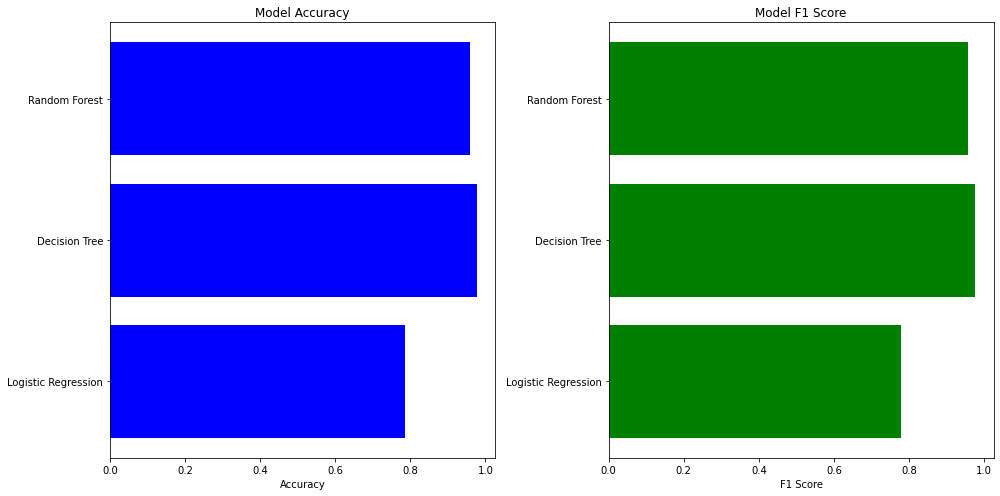

In [51]:
# Visualization
import matplotlib.pyplot as plt

# Collect the summary data to plot
summary_pd = summary_df.toPandas()

# Plot accuracy and RMSE
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.barh(summary_pd['Model'], summary_pd['Accuracy'], color='blue')
plt.xlabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.barh(summary_pd['Model'], summary_pd['F1 Score'], color='green')
plt.xlabel('F1 Score')
plt.title('Model F1 Score')

plt.tight_layout()
plt.show()


## ARIMA Model

In [52]:
pdf = new_df


In [53]:
pdf = pdf.orderBy(col("from_date"))

In [54]:
# Convert to Pandas DataFrame for ARIMA modeling
pandas_df = pdf.toPandas()

# Set the date as the index
pandas_df.set_index('from_date', inplace=True)

In [55]:
import pmdarima as pm
from pmdarima import model_selection

# Split data into train and test
train, test = model_selection.train_test_split(pandas_df, test_size=0.2)

# Fit the ARIMA model
arima_model = pm.auto_arima(train['pm10_ug_m3'], 
                            start_p=1, start_q=1,
                            test='adf',
                            max_p=3, max_q=3, m=1,
                            start_P=0, seasonal=False,
                            d=None, D=0, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

# Summary of the model
print(arima_model.summary())

# Forecast
forecast, conf_int = arima_model.predict(n_periods=len(test), return_conf_int=True)

# Convert results to a DataFrame for visualization or further processing
forecast_df = pd.DataFrame(forecast, index=test.index, columns=['forecast'])

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(test['pm10_ug_m3'], forecast_df['forecast']))

# Print the RMSE
print(f"RMSE: {rmse}")

forecast_df

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=930289.597, Time=42.57 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1056173.939, Time=2.51 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=980060.367, Time=2.93 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1018114.597, Time=14.28 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=930018.176, Time=67.80 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=960581.397, Time=5.63 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=929802.019, Time=43.89 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=943738.678, Time=7.17 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=929463.332, Time=104.19 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=929988.859, Time=55.69 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=928665.163, Time=133.79 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=929637.436, Time=100.40 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=930278.325, Time=293.69 sec

Best model:  ARIMA(3,0,3)(0,0,0)[0]          
Total fit t

,forecast
from_date,
2022-12-10 22:00:00,144.208718
2022-12-10 23:00:00,147.397326
2022-12-10 23:00:00,150.401319
2022-12-10 23:00:00,147.466063
2022-12-10 23:00:00,145.767647
...,...
2023-03-31 23:00:00,0.000035
2023-03-31 23:00:00,0.000035
2023-03-31 23:00:00,0.000035


Evaluation Metrics
Once you've tuned your model, you'll need to evaluate its performance using metrics like:

AIC (Akaike Information Criterion): Lower AIC indicates a better model (relative to others).
BIC (Bayesian Information Criterion): Similar to AIC, but with a penalty for the number of parameters.
RMSE (Root Mean Squared Error): Measures the difference between predicted and observed values.
MAE (Mean Absolute Error): The average of the absolute differences between predicted and observed values.

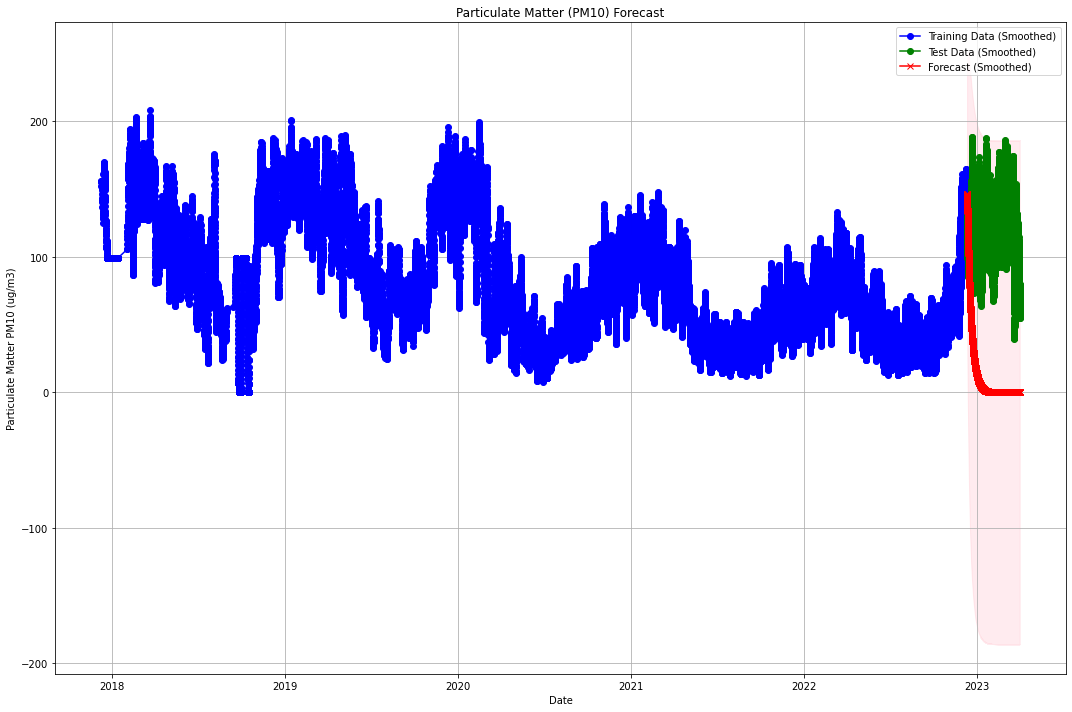

In [56]:
import matplotlib.pyplot as plt

forecast_df = pd.DataFrame({
    'forecast': forecast, 
    'lower_ci': conf_int[:, 0], 
    'upper_ci': conf_int[:, 1]
}, index=test.index)


train_smoothed = train['pm10_ug_m3'].rolling(window=30).mean()
test_smoothed = test['pm10_ug_m3'].rolling(window=30).mean()
forecast_smoothed = forecast_df['forecast'].rolling(window=30).mean()

# Plot the actual vs forecast
plt.figure(figsize=(15, 10))

plt.plot(train.index, train_smoothed, label='Training Data (Smoothed)', linestyle='-', marker='o', color='blue')
plt.plot(test.index, test_smoothed, label='Test Data (Smoothed)', linestyle='-', marker='o', color='green')
plt.plot(forecast_df.index, forecast_smoothed, label='Forecast (Smoothed)', color='red', linestyle='-', marker='x')

# Fill between the confidence intervals
plt.fill_between(forecast_df.index, 
                 forecast_df['lower_ci'], forecast_df['upper_ci'], 
                 color='pink', alpha=0.3)  # Reduced opacity

plt.title('Particulate Matter (PM10) Forecast')
plt.xlabel('Date')
plt.ylabel('Particulate Matter PM10 (ug/m3)')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust subplots to fit in figure area
plt.show()


In [57]:
#!pip install pmdarima

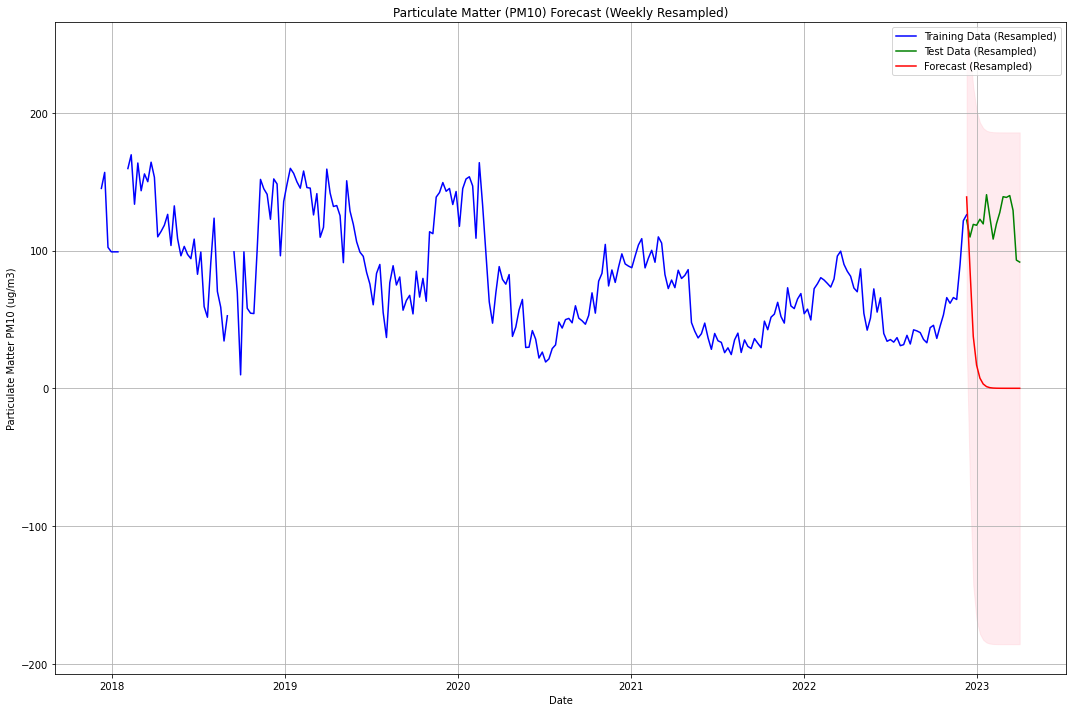

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming forecast and conf_int are aligned with test
forecast_df = pd.DataFrame({
    'forecast': forecast, 
    'lower_ci': conf_int[:, 0], 
    'upper_ci': conf_int[:, 1]
}, index=test.index)

# Resample data to a weekly average 
train_resampled = train['pm10_ug_m3'].resample('W').mean()
test_resampled = test['pm10_ug_m3'].resample('W').mean()
forecast_resampled = forecast_df['forecast'].resample('W').mean()
conf_int_resampled_lower = forecast_df['lower_ci'].resample('W').mean()
conf_int_resampled_upper = forecast_df['upper_ci'].resample('W').mean()

# Plot the actual vs forecast with increased smoothing and resampling
plt.figure(figsize=(15, 10))

plt.plot(train_resampled.index, train_resampled, label='Training Data (Resampled)', linestyle='-', color='blue')
plt.plot(test_resampled.index, test_resampled, label='Test Data (Resampled)', linestyle='-', color='green')
plt.plot(forecast_resampled.index, forecast_resampled, label='Forecast (Resampled)', color='red', linestyle='-')

# Fill between the resampled confidence intervals
plt.fill_between(forecast_resampled.index, 
                 conf_int_resampled_lower, conf_int_resampled_upper, 
                 color='pink', alpha=0.3)  # Reduced opacity

plt.title('Particulate Matter (PM10) Forecast (Weekly Resampled)')
plt.xlabel('Date')
plt.ylabel('Particulate Matter PM10 (ug/m3)')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust subplots to fit in figure area
plt.show()


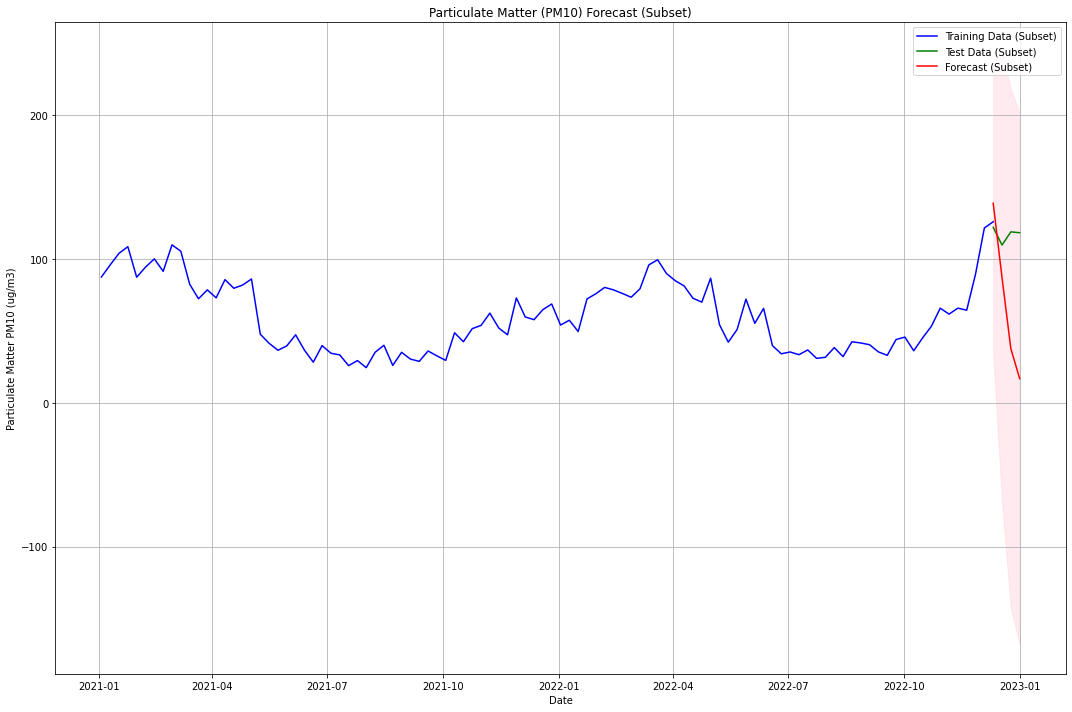

In [59]:
#Resample data to a weekly average (you can change this to monthly if still too noisy)
train_resampled = train['pm10_ug_m3'].resample('W').mean()
test_resampled = test['pm10_ug_m3'].resample('W').mean()
forecast_resampled = forecast_df['forecast'].resample('W').mean()
conf_int_resampled_lower = forecast_df['lower_ci'].resample('W').mean()
conf_int_resampled_upper = forecast_df['upper_ci'].resample('W').mean()

# for subset of the data, do the following:
subset_start = '2021-01-01'
subset_end = '2023-01-01'

train_subset = train_resampled.loc[subset_start:subset_end]
test_subset = test_resampled.loc[subset_start:subset_end]
forecast_subset = forecast_resampled.loc[subset_start:subset_end]
conf_int_subset_lower = conf_int_resampled_lower.loc[subset_start:subset_end]
conf_int_subset_upper = conf_int_resampled_upper.loc[subset_start:subset_end]

# Plotting the subset
plt.figure(figsize=(15, 10))

plt.plot(train_subset.index, train_subset, label='Training Data (Subset)', linestyle='-', color='blue')
plt.plot(test_subset.index, test_subset, label='Test Data (Subset)', linestyle='-', color='green')
plt.plot(forecast_subset.index, forecast_subset, label='Forecast (Subset)', color='red', linestyle='-')

plt.fill_between(forecast_subset.index, 
                 conf_int_subset_lower, conf_int_subset_upper, 
                 color='pink', alpha=0.3)  # Reduced opacity

plt.title('Particulate Matter (PM10) Forecast (Subset)')
plt.xlabel('Date')
plt.ylabel('Particulate Matter PM10 (ug/m3)')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust subplots to fit in figure area
plt.show()

## Feature Scaling

In [60]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler


Assemble Features:
You need to assemble the features into a single vector before applying the scaler.

<!-- Assemble Features:
You need to assemble the features into a single vector before applying the scaler. -->

In [61]:
numeric_columns= [col[0] for col in new_df.dtypes if col[1] in ("IntegerType", "double")]
numeric_columns

['co_mg_m3',
 'so2_ug_m3',
 'ozone_ug_m3',
 'pm10_ug_m3',
 'no2_ug_m3',
 'pm2_5_ug_m3']

In [62]:
# Assemble the features into a feature vector
assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
df_vector = assembler.transform(new_df)

Apply StandardScaler:
Use StandardScaler to standardize the features. StandardScaler standardizes features by removing the mean and scaling to unit variance.

In [63]:
# Initialize the StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)

# Fit the scaler to the data and transform the features
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)


In [64]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import DenseVector
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, DoubleType

# Define a UDF to convert vector to an array
def vector_to_array_udf(v):
    return v.toArray().tolist()

# Register the UDF
vector_to_array_udf = udf(vector_to_array_udf, ArrayType(DoubleType()))

# Convert the scaled features vector into an array
df_scaled = df_scaled.withColumn("scaledFeaturesArray", vector_to_array_udf(F.col("scaledFeatures")))

# Replace each original column with its scaled version
for i, col_name in enumerate(numeric_columns):
    df_scaled = df_scaled.withColumn(col_name, F.col("scaledFeaturesArray")[i])

# Drop intermediate columns
df_scaled = df_scaled.drop("features", "scaledFeatures", "scaledFeaturesArray")

In [65]:
df_scaled.limit(5).toPandas()

,co_mg_m3,so2_ug_m3,ozone_ug_m3,pm10_ug_m3,no2_ug_m3,pm2_5_ug_m3,from_date,to_date,state,AQI_Category
0,-0.509359,-0.980122,-0.559035,-0.286707,-0.899465,-0.967304,2020-03-21 02:00:00,2020-03-21 03:00:00,Mizoram,Moderate
1,-0.661821,-0.816675,-0.528162,-0.506735,-0.888356,-0.967304,2020-03-24 17:00:00,2020-03-24 18:00:00,Mizoram,Moderate
2,-0.445833,-0.910971,-0.599304,0.131364,-0.902884,-0.967304,2020-03-24 23:00:00,2020-03-25 00:00:00,Mizoram,Moderate
3,-0.661821,-0.796917,-0.389903,-0.666301,-0.903738,-0.378711,2020-03-28 09:00:00,2020-03-28 10:00:00,Mizoram,Good
4,-0.661821,-0.964855,-0.718770,-0.806304,-0.828539,-0.349527,2020-04-13 11:00:00,2020-04-13 12:00:00,Mizoram,Good


UDF Definition: A UDF is defined to convert a DenseVector (used in PySpark) into an array.
UDF Registration: The UDF is registered and used to create an array column from the scaled feature vector.
Column Replacement: Each original numeric column is replaced with its corresponding scaled version.
Final Output:
After running the code, the df_scaled DataFrame will have the original numeric columns replaced by their scaled versions, and non-numeric columns (like categorical or timestamp columns) will remain unchanged. This method allows you to scale features even if you're using an older version of PySpark.

## 1) Prepare data for Modeling

In [66]:
# StringIndexer for the categorical target column
indexer = StringIndexer(inputCol='AQI_Category', outputCol='label')

# VectorAssembler to combine feature columns into a single vector
feature_cols = [col for col in df_scaled.columns if col not in ['AQI_Category', 'from_date', 'to_date', 'state']]
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

# Split the data into training and testing sets
train_df, test_df = df_scaled.randomSplit([0.8, 0.2], seed=42)

## 2) Model Building using Hyper Parameter Tuning

In [67]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Import the machine learning models
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier

# Define models
lr = LogisticRegression(maxIter=10)
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

# Define hyperparameter grids
lr_param_grid = (ParamGridBuilder()
                 .addGrid(lr.regParam, [0.1, 0.01])
                 .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
                 .build())

dt_param_grid = (ParamGridBuilder()
                 .addGrid(dt.maxDepth, [5, 10, 20])
                 .addGrid(dt.maxBins, [32, 64])
                 .build())

rf_param_grid = (ParamGridBuilder()
                 .addGrid(rf.numTrees, [20, 50])
                 .addGrid(rf.maxDepth, [5, 10])
                 .build())

# Define CrossValidator
crossval = CrossValidator(estimator=None,
                          estimatorParamMaps=None,
                          evaluator=MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy'),
                          numFolds=3)

# Set up pipelines and cross-validate each model
def cross_validate_model(model, param_grid, train_df):
    pipeline = Pipeline(stages=[indexer, assembler, model])
    crossval.setEstimator(pipeline)
    crossval.setEstimatorParamMaps(param_grid)
    cv_model = crossval.fit(train_df)
    return cv_model

# Train and tune models
lr_model = cross_validate_model(lr, lr_param_grid, train_df)
dt_model = cross_validate_model(dt, dt_param_grid, train_df)
rf_model = cross_validate_model(rf, rf_param_grid, train_df)  

## 3) Model Evaluation

In [68]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate models
models = ['Logistic Regression', 'Decision Tree', 'Random Forest']
predictions = [lr_model.transform(test_df), 
               dt_model.transform(test_df), 
               rf_model.transform(test_df)]

# Initialize evaluators
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
precision_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedPrecision')
recall_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedRecall')
f1_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')

accuracies = []
precisions = []
recalls = []
f1_scores = []

for preds in predictions:
    accuracy = accuracy_evaluator.evaluate(preds)
    precision = precision_evaluator.evaluate(preds)
    recall = recall_evaluator.evaluate(preds)
    f1_score = f1_evaluator.evaluate(preds)
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

# Create a summary DataFrame for comparison
summary_df = spark.createDataFrame(zip(models, accuracies, precisions, recalls, f1_scores), 
                                   schema=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Display the summary
summary_df.show()


+-------------------+------------------+------------------+------------------+------------------+
|              Model|          Accuracy|         Precision|            Recall|          F1 Score|
+-------------------+------------------+------------------+------------------+------------------+
|Logistic Regression|0.8358371533608678|0.8218944693714303|0.8358371533608677|0.8228211102539591|
|      Decision Tree|0.9766259701357055|0.9779128327499461|0.9766259701357055|0.9761878302476614|
|      Random Forest|0.9586529296963645|0.9608271639603619|0.9586529296963645|0.9573486266767322|
+-------------------+------------------+------------------+------------------+------------------+



## 4) Visualization

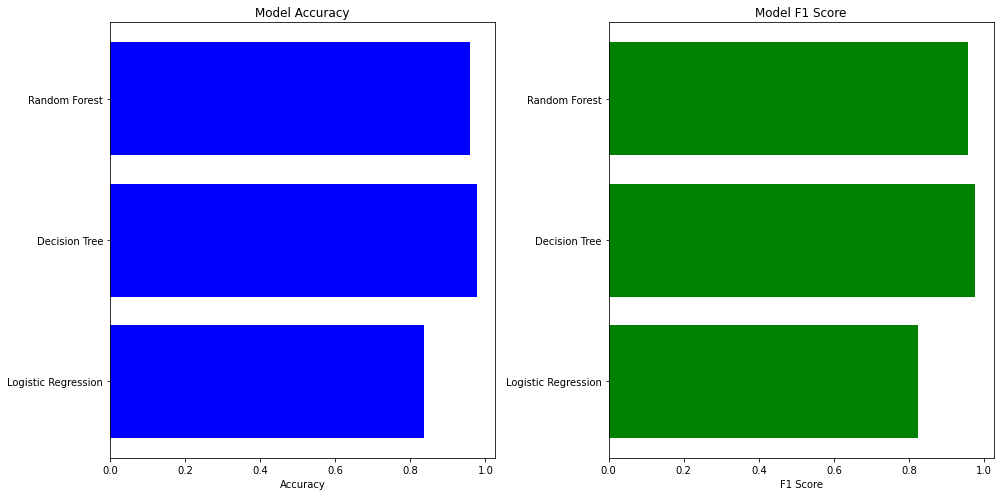

In [70]:
# Visualization
import matplotlib.pyplot as plt

# Collect the summary data to plot
summary_pd = summary_df.toPandas()

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.barh(summary_pd['Model'], summary_pd['Accuracy'], color='blue')
plt.xlabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.barh(summary_pd['Model'], summary_pd['F1 Score'], color='green')
plt.xlabel('F1 Score')
plt.title('Model F1 Score')

plt.tight_layout()
plt.show()


## ARIMA model On Scaled Data

In [71]:
pdf1=new_df

In [72]:
pdf1 = pdf1.orderBy(col("from_date"))

In [73]:
# Convert to Pandas DataFrame for ARIMA modeling
pandas_df1 = pdf1.toPandas()

# Set the date as the index
pandas_df1.set_index('from_date', inplace=True)

In [74]:
import pmdarima as pm
from pmdarima import model_selection

# Split data into train and test
train, test = model_selection.train_test_split(pandas_df1, test_size=0.2)

# Fit the ARIMA model
arima_model = pm.auto_arima(train['pm10_ug_m3'], 
                            start_p=1, start_q=1,
                            test='adf',
                            max_p=3, max_q=3, m=1,
                            start_P=0, seasonal=False,
                            d=None, D=0, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

# Summary of the model
print(arima_model.summary())

# Forecast
forecast, conf_int = arima_model.predict(n_periods=len(test), return_conf_int=True)

# Convert results to a DataFrame for visualization or further processing
forecast_df1 = pd.DataFrame(forecast, index=test.index, columns=['forecast'])


# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(test['pm10_ug_m3'], forecast_df['forecast']))

# Print the RMSE
print(f"RMSE: {rmse}")

forecast_df1


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=930289.597, Time=29.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1056173.939, Time=2.42 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=980060.367, Time=2.88 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1018114.597, Time=14.93 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=930018.176, Time=62.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=960581.397, Time=5.82 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=929802.019, Time=46.62 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=943738.678, Time=7.54 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=929463.332, Time=108.33 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=929988.859, Time=58.01 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=928665.163, Time=135.34 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=929637.436, Time=105.41 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=930278.325, Time=296.17 sec

Best model:  ARIMA(3,0,3)(0,0,0)[0]          
Total fit t

,forecast
from_date,
2022-12-10 22:00:00,144.208718
2022-12-10 23:00:00,147.397326
2022-12-10 23:00:00,150.401319
2022-12-10 23:00:00,147.466063
2022-12-10 23:00:00,145.767647
...,...
2023-03-31 23:00:00,0.000035
2023-03-31 23:00:00,0.000035
2023-03-31 23:00:00,0.000035


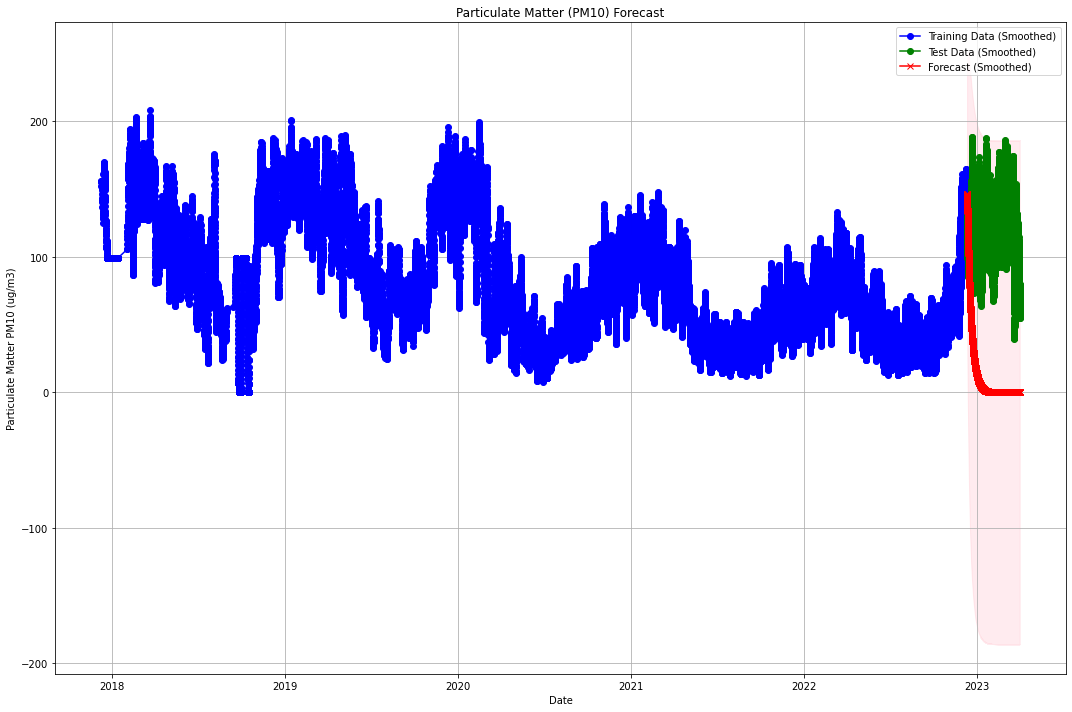

In [75]:
import matplotlib.pyplot as plt

# Assuming forecast and conf_int are aligned with test
forecast_df1 = pd.DataFrame({
    'forecast': forecast, 
    'lower_ci': conf_int[:, 0], 
    'upper_ci': conf_int[:, 1]
}, index=test.index)

train_smoothed = train['pm10_ug_m3'].rolling(window=30).mean()
test_smoothed = test['pm10_ug_m3'].rolling(window=30).mean()
forecast_smoothed = forecast_df1['forecast'].rolling(window=30).mean()

# Plot the actual vs forecast
plt.figure(figsize=(15, 10))

plt.plot(train.index, train_smoothed, label='Training Data (Smoothed)', linestyle='-', marker='o', color='blue')
plt.plot(test.index, test_smoothed, label='Test Data (Smoothed)', linestyle='-', marker='o', color='green')
plt.plot(forecast_df1.index, forecast_smoothed, label='Forecast (Smoothed)', color='red', linestyle='-', marker='x')

# Fill between the confidence intervals
plt.fill_between(forecast_df1.index, 
                 forecast_df1['lower_ci'], forecast_df1['upper_ci'], 
                 color='pink', alpha=0.3)  # Reduced opacity

plt.title('Particulate Matter (PM10) Forecast')
plt.xlabel('Date')
plt.ylabel('Particulate Matter PM10 (ug/m3)')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust subplots to fit in figure area
plt.show()

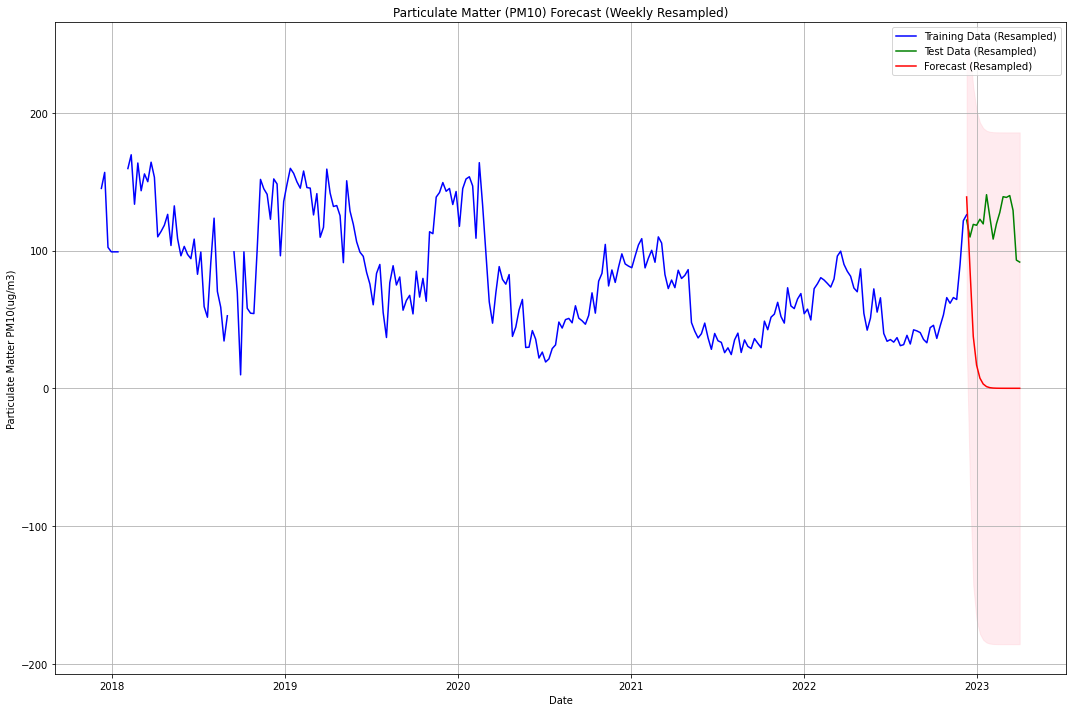

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming forecast and conf_int are aligned with test
forecast_df1 = pd.DataFrame({
    'forecast': forecast, 
    'lower_ci': conf_int[:, 0], 
    'upper_ci': conf_int[:, 1]
}, index=test.index)

# Resample data to a weekly average (you can change this to monthly if still too noisy)
train_resampled = train['pm10_ug_m3'].resample('W').mean()
test_resampled = test['pm10_ug_m3'].resample('W').mean()
forecast_resampled = forecast_df1['forecast'].resample('W').mean()
conf_int_resampled_lower = forecast_df1['lower_ci'].resample('W').mean()
conf_int_resampled_upper = forecast_df1['upper_ci'].resample('W').mean()

# Plot the actual vs forecast with increased smoothing and resampling
plt.figure(figsize=(15, 10))

plt.plot(train_resampled.index, train_resampled, label='Training Data (Resampled)', linestyle='-', color='blue')
plt.plot(test_resampled.index, test_resampled, label='Test Data (Resampled)', linestyle='-', color='green')
plt.plot(forecast_resampled.index, forecast_resampled, label='Forecast (Resampled)', color='red', linestyle='-')

# Fill between the resampled confidence intervals
plt.fill_between(forecast_resampled.index, 
                 conf_int_resampled_lower, conf_int_resampled_upper, 
                 color='pink', alpha=0.3)  # Reduced opacity

plt.title('Particulate Matter (PM10) Forecast (Weekly Resampled)')
plt.xlabel('Date')
plt.ylabel('Particulate Matter PM10(ug/m3)')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust subplots to fit in figure area
plt.show()


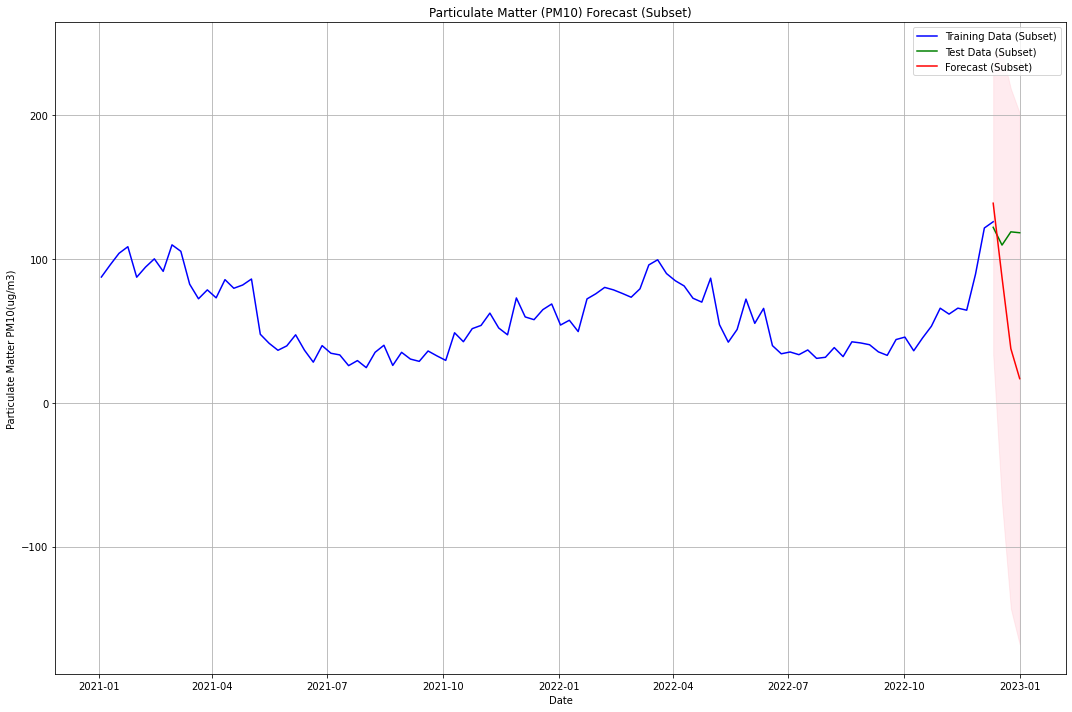

In [77]:
#Resample data to a weekly average (you can change this to monthly if still too noisy)
train_resampled = train['pm10_ug_m3'].resample('W').mean()
test_resampled = test['pm10_ug_m3'].resample('W').mean()
forecast_resampled = forecast_df1['forecast'].resample('W').mean()
conf_int_resampled_lower = forecast_df1['lower_ci'].resample('W').mean()
conf_int_resampled_upper = forecast_df1['upper_ci'].resample('W').mean()

# if you want to focus on a subset of the data, do the following:
subset_start = '2021-01-01'
subset_end = '2023-01-01'

train_subset = train_resampled.loc[subset_start:subset_end]
test_subset = test_resampled.loc[subset_start:subset_end]
forecast_subset = forecast_resampled.loc[subset_start:subset_end]
conf_int_subset_lower = conf_int_resampled_lower.loc[subset_start:subset_end]
conf_int_subset_upper = conf_int_resampled_upper.loc[subset_start:subset_end]

# Plotting the subset
plt.figure(figsize=(15, 10))

plt.plot(train_subset.index, train_subset, label='Training Data (Subset)', linestyle='-', color='blue')
plt.plot(test_subset.index, test_subset, label='Test Data (Subset)', linestyle='-', color='green')
plt.plot(forecast_subset.index, forecast_subset, label='Forecast (Subset)', color='red', linestyle='-')

plt.fill_between(forecast_subset.index, 
                 conf_int_subset_lower, conf_int_subset_upper, 
                 color='pink', alpha=0.3)  # Reduced opacity

plt.title('Particulate Matter (PM10) Forecast (Subset)')
plt.xlabel('Date')
plt.ylabel('Particulate Matter PM10(ug/m3)')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust subplots to fit in figure area
plt.show()

In [78]:
#new_df.toPandas()

In [ ]:
#new_df.coalesce(1).write.parquet("file:///home/talentum/P2/For_tableau")

## SARIMA Model

In [79]:
pdf=new_df

In [ ]:
# Convert to Pandas DataFrame for SARIMA modeling
pandas_df = pdf.toPandas()

# Set the date as the index
pandas_df.set_index('from_date', inplace=True)

import pmdarima as pm
from pmdarima import model_selection

# Split data into train and test
train, test = model_selection.train_test_split(pandas_df, test_size=0.2)

# Fit the SARIMA model
sarima_model = pm.auto_arima(train['pm10_ug_m3'], 
                             start_p=1, start_q=1,
                             test='adf',       # Augmented Dickey-Fuller test for stationarity
                             max_p=3, max_q=3, 
                             m=12,            # Set m to the number of periods per season (e.g., 12 for monthly data if seasonality is yearly)
                             start_P=0, seasonal=True,  # Enable seasonal component
                             d=None, D=1, trace=True,   # Let the model figure out the best differencing
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)

# Summary of the model
print(sarima_model.summary())

# Forecast
forecast, conf_int = sarima_model.predict(n_periods=len(test), return_conf_int=True)


# Convert results to a DataFrame for visualization or further processing
forecast_df = pd.DataFrame(forecast, index=test.index, columns=['forecast'])


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['pm10_ug_m3'], forecast_df['forecast']))

# Print the RMSE value
print(f'RMSE: {rmse}')

forecast_df

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1406.30 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1005138.709, Time=95.57 sec
